In [ ]:
!pip install --upgrade pip
!pip install --upgrade tensorflow

In [1]:
import numpy as np

CUSTOM_SEED = 113
np.random.seed(CUSTOM_SEED)

In [2]:
import nltk

nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     /Users/ragnarjok/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

In [3]:
from nltk.corpus import treebank
sentences = treebank.tagged_sents()

In [4]:
len(sentences)

3914

In [5]:
tags = set([
    tag for sentence in sentences 
    for _, tag in sentence
])
print('nb_tags: %sntags: %s' % (len(tags), tags))

nb_tags: 46ntags: {'-NONE-', ':', '$', 'LS', 'JJ', 'TO', 'POS', 'VBD', 'RP', 'PRP$', "''", 'MD', 'WDT', '-LRB-', 'NN', 'PDT', 'NNS', 'JJS', 'EX', 'VBN', 'JJR', 'SYM', 'IN', 'VBZ', ',', 'VBG', 'CD', '.', 'RB', 'WP', 'CC', 'PRP', 'NNPS', '-RRB-', 'WRB', 'WP$', 'RBS', '``', 'UH', '#', 'VBP', 'NNP', 'FW', 'VB', 'DT', 'RBR'}


In [6]:
def add_basic_features(sentence_terms, sentence_length, index):
    """ Compute some very basic word features.

        :param sentence_terms: [w1, w2, ...] 
        :type sentence_terms: list
        :param index: the index of the word 
        :type index: int
        :return: dict containing features
        :rtype: dict
    """
    term = sentence_terms[index]
    return {
        'nb_terms': sentence_length,
        'term': term,
        'is_first': index == 0,
        'is_last': index == sentence_length - 1,
        'is_capitalized': term[0].upper() == term[0],
        'is_all_caps': term.upper() == term,
        'is_all_lower': term.lower() == term,
        'prefix-1': term[0],
        'prefix-2': term[:2],
        'prefix-3': term[:3],
        'suffix-1': term[-1],
        'suffix-2': term[-2:],
        'suffix-3': term[-3:],
        'prev_word': '' if index == 0 else sentence_terms[index - 1],
        'next_word': '' if index == sentence_length - 1 else sentence_terms[index + 1]
    }

In [7]:
def untag(tagged_sentence):
    """ 
    Remove the tag for each tagged term.
    :param tagged_sentence: a POS tagged sentence
    :type tagged_sentence: list
    :return: a list of tags
    :rtype: list of strings
    """
    return [w for w, _ in tagged_sentence]

def transform_to_dataset(tagged_sentences):
    """
    Split tagged sentences to X and y datasets and append some basic features.
    :param tagged_sentences: a list of POS tagged sentences
    :param tagged_sentences: list of list of tuples (term_i, tag_i)
    :return: 
    """
    X, y = [], []
    for pos_tags in tagged_sentences:
        untagged = untag(pos_tags)
        untagged_length = len(untagged)
        for index, (term, class_) in enumerate(pos_tags):
            # Add basic NLP features for each sentence term
            X.append(add_basic_features(untagged, untagged_length, index))
            y.append(class_)
    return X, y

In [8]:
ds_X, ds_y = transform_to_dataset(sentences)
tokens_count = len(ds_X)
from sklearn.feature_extraction import DictVectorizer
# Fit our DictVectorizer with our set of features
dict_vectorizer = DictVectorizer(sparse=False)
dict_vectorizer.fit(ds_X)


from sklearn.preprocessing import LabelEncoder
# Fit LabelEncoder with our list of classes
label_encoder = LabelEncoder()
label_encoder.fit(ds_y)

LabelEncoder()

In [9]:
from keras.utils import np_utils

def normalize_X_y(ds_X, ds_y, start, end):
    X = dict_vectorizer.transform(ds_X[start:end])
    y = np_utils.to_categorical(label_encoder.transform(ds_y[start:end]))
    return X, y

Using TensorFlow backend.


In [10]:
start = 0
start_1 = int(tokens_count * 0.5)
start_2 = int(tokens_count * 0.75)
end = tokens_count 

X_train, y_train = normalize_X_y(ds_X, ds_y, start, start_1)
X_test, y_test =normalize_X_y(ds_X, ds_y, start_1, start_2)
X_val, y_val = normalize_X_y(ds_X, ds_y, start_2, end)

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

def build_model(input_dim, hidden_neurons, output_dim):
    """
    Construct, compile and return a Keras model which will be used to fit/predict
    """
    model = Sequential([
        Dense(hidden_neurons, input_dim=input_dim),
        Activation('relu'),
        Dropout(0.5),
        Dense(hidden_neurons),
        Activation('relu'),
        Dropout(0.75),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model



In [15]:
from keras.wrappers.scikit_learn import KerasClassifier

model_params = {
    'build_fn': build_model,
    'input_dim': X_train.shape[1],
    'hidden_neurons': 512,
    'output_dim': y_train.shape[1],
    'epochs': 4,
    'batch_size': 128,
    'verbose': 1,
    'validation_data': (X_val, y_val),
    'shuffle': True
}

clf = KerasClassifier(**model_params)

In [16]:
hist = clf.fit(X_train, y_train)

Train on 50338 samples, validate on 25169 samples
Epoch 1/4
50338/50338 [==============================] - 225s 4ms/step - loss: 1.0311 - acc: 0.7353 - val_loss: 0.2526 - val_acc: 0.9211
Epoch 2/4
50338/50338 [==============================] - 220s 4ms/step - loss: 0.2620 - acc: 0.9259 - val_loss: 0.1779 - val_acc: 0.9415
Epoch 3/4
50338/50338 [==============================] - 212s 4ms/step - loss: 0.1646 - acc: 0.9529 - val_loss: 0.1557 - val_acc: 0.9482
Epoch 4/4
50338/50338 [==============================] - 223s 4ms/step - loss: 0.1227 - acc: 0.9646 - val_loss: 0.1587 - val_acc: 0.9483


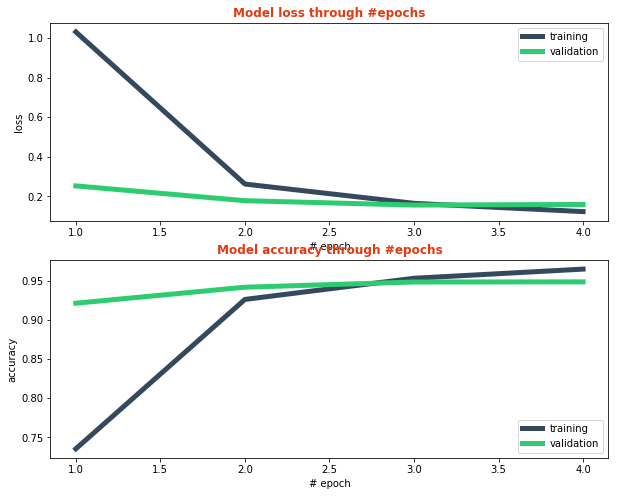

In [17]:
import matplotlib.pyplot as plt

def plot_model_performance(train_loss, train_acc, train_val_loss, train_val_acc):
    """ Plot model loss and accuracy through epochs. """

    blue= '#34495E'
    green = '#2ECC71'
    orange = '#E23B13'

    # plot model loss
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))
    ax1.plot(range(1, len(train_loss) + 1), train_loss, blue, linewidth=5, label='training')
    ax1.plot(range(1, len(train_val_loss) + 1), train_val_loss, green, linewidth=5, label='validation')
    ax1.set_xlabel('# epoch')
    ax1.set_ylabel('loss')
    ax1.tick_params('y')
    ax1.legend(loc='upper right', shadow=False)
    ax1.set_title('Model loss through #epochs', color=orange, fontweight='bold')

    # plot model accuracy
    ax2.plot(range(1, len(train_acc) + 1), train_acc, blue, linewidth=5, label='training')
    ax2.plot(range(1, len(train_val_acc) + 1), train_val_acc, green, linewidth=5, label='validation')
    ax2.set_xlabel('# epoch')
    ax2.set_ylabel('accuracy')
    ax2.tick_params('y')
    ax2.legend(loc='lower right', shadow=False)
    ax2.set_title('Model accuracy through #epochs', color=orange, fontweight='bold')
    plt.show()

plot_model_performance(
    train_loss=hist.history.get('loss', []),
    train_acc=hist.history.get('acc', []),
    train_val_loss=hist.history.get('val_loss', []),
    train_val_acc=hist.history.get('val_acc', [])
)


In [18]:
score = clf.score(X_test, y_test)
print(score)

25169/25169 [==============================] - 30s 1ms/step
0.946203663187


In [19]:
clf.model.save('/tmp/keras_mlp.h5')

In [20]:
clf.n_classes_

46

In [29]:
sentence = 'This is called a bare repository - it contains the contents of what would normally be in a .git folder.'
split = sentence.split()

x = []
for index, (term) in enumerate(split):
    x.append(add_basic_features(split, len(split), index))
       

In [30]:
x = dict_vectorizer.transform(x)

In [32]:
label_encoder.inverse_transform(clf.predict(x))

20/20 [==============================] - 0s 2ms/step


array(['DT', 'VBZ', 'VBN', 'DT', 'NN', 'NN', ':', 'PRP', 'VBZ', 'DT',
       'NNS', 'IN', 'WP', 'MD', 'RB', 'VB', 'IN', 'DT', 'JJ', '.'],
      dtype='<U6')